In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# étude du mouvement d'un pélamis dans la houle
L'objectif est d'étudier le mouvement du pélamis dans la houle et d'optimiser ses caractéristiques (Longueur L, masse m, rayon R) afin de maximiser son mouvement et donc l'énergie récupérable.

Dans une première partie, on étudiera la houle. Après une rapide présentation du pélamis, une étude théorique simplifiée de son mouvement dans l'eau sera réalisée.

##  1. La houle
Le mouvement des vagues a fait l'objet de nombreuses études (référence....) et la modélisation de ce phénomène est toujours un problème actuel notamment lors de la construction d'édifice "off-shore" (plateforme pétrolière, champ d'éolienne, ...)

Dans ce problème, on considèrera que la houle est une onde monochromatique se propageant dans la direction $x$. On note $\eta(x,t)$ l'élévation du niveau de l'eau par rapport au niveau de mer calme. Cela s'exprime alors:
$$\eta(x,t)=\eta_0\cos\left(\omega t- kx\right)$$ avec $w$ et $k$ respectivement la pulsation et le vecteur d'onde. Ces deux grandeurs sont reliées par une relation de dispersion.
Dans le cas de mer profondes, la relation de dispersion est relativement simple et s'écrit: 
$$ \omega^2 = gk $$ où $g$ est l'accélération de la pesanteur.

In [22]:
g=9.81 #m.s^-2     accélération de la pesanteur
eta0 = 3 #m   amplitude des vagues
f = 0.15 #Hz   fréquence de la houle
w = 2*np.pi*f # pulsation de la houle

On écrit une fonction $\texttt{def eta(x,t)}$ qui renvoie l'hauteur d'eau à l'instant $t$ et à la position $x$.

In [3]:
def k(w):
    return w**2/g

def eta(x,t):
    return eta0*np.sin(w*t-k(w)*x)
    

On peut alors représenter la vague à plusieurs instants sur deux périodes spatiales:

La longueur d'onde de la vague est: 624.5239966925974


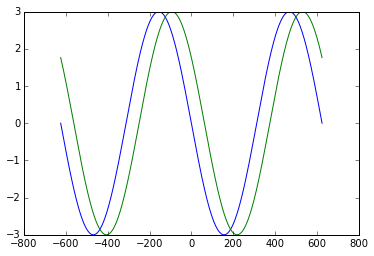

In [4]:
lvag = 2*np.pi/k(w) #m  longueur d'onde de la houle
print("La longueur d'onde de la vague est:", lvag)
x=np.linspace(-lvag,lvag,1e3)
plt.plot(x,eta(x,0))
plt.plot(x,eta(x,2))

In [5]:
print("la vitesse de phase est: ",w/k(w), "m/s")
print("la vitesse de groupe est: ",0.5*np.sqrt(g/k(w)), "m/s")

la vitesse de phase est:  31.22619983462987 m/s
la vitesse de groupe est:  15.6130999173 m/s


La houle est créé par un mouvement circulaires des particules fluides de l'eau dont la vitesse peut s'exprimer en base cartésienne (avec $x$ la direction de propagation de la vague et $z$ suivant la verticale):
$$ \vec{v}=\eta_{0}\omega e^{kz}cos(\omega t-kx)\vec{e_{x}}-\eta_{0}\omega e^{kz}sin(\omega t-kx)\vec{e_{z}}
  \quad \textrm{avec}\quad k\eta_{0}\ll 1 $$
 
 Vérifions que la condition $k\eta_{0}\ll 1 $ est bien vérifiée ici puis écrivons une fonction qui permet de déterminer la vitesse d'une particule de fluide. Cet fonction $\texttt{v}\_ \texttt{eau(XYZ,t)}$ prend un tableau à 3D en entrée qui est la position considérée ainsi que l'instant considéré. Elle renvoie un tableau 3D des vitesses suivant les 3 axes cartésiens.
 
 ** Remarque:** on envoie un tableau 3D en entrée bien qu'il y ait invariance par translation (mouvement plan des particules de fluides).

In [6]:
def v_eau(XYZ,t):
    kk=k(w)
    x=XYZ[0]
    z=XYZ[2]
    vx=eta0*w*np.exp(kk*z)*np.cos(w*t-kk*x)
    vz=-eta0*w*np.exp(kk*z)*np.sin(w*t-kk*x)
    return [vx,0,vz]

On verra dans la suite qu'il est intéressant de connaitre la valeur de la surpression dynamique en un point de l'eau de la formule:
$$P(x,z,t)=\rho g \left(\eta(x,t) + z \right) + \frac{1}{2}\rho v^2 $$
ATTENTION AU SIGNE DE $(\eta(x,t) + z )$

On défini donc une fonction $\texttt{ Pression(XYZ,t)}$ qui prend un tableau 3D de la position en entrée et le temps et qui renvoie la valeur de la pression à ce point.


In [27]:
rho_e = 1e3 #kg.m^-3  mase volumique de l'eau


def Pression(XYZ,t):
    """ fonction qui renvoie la valeur de la surpression due aux vagues au niveau de la 
    position XYZ dans le référentiel du labo et à l'instant t"""
    eta_vague=eta(XYZ[0],t)
    if XYZ[2] > eta_vague:
        """ on est au-dessus du niveau d'eau """
        return 0
    else:
        Vmer= v_eau(XYZ,t) 
        return rho_e*g*(eta_vague-XYZ[2])+0.2*rho_e/2*(Vmer[0]**2+Vmer[1]**2+Vmer[2]**2)

## 2. Le pelamis
Le pelamis est un cylindre qui flotte sur la mer. Le mouvement des vagues entraine un mouvement pendulaire de transition et de rotation du cylindre qui permet de récupérer cette énergie en vue de la production d'électricité.
![Pelamis](Pelamis.png)

Les dimensions du pélamis sont les suivantes:
* masse $m = 175\cdot 10^3\, kg$ 
* longueur $L = 24\, m$
* rayon $R = 3\, m$

Le moment d'inertie de ce cylindre oscillant autour de l'axe $Oy$ est 
$$ J = \frac{m}{12}\left(3R^2+L^2\right) $$

In [8]:
m = 100e3#175e3 #kg masse du cylindre
L = 24 #m longueur du cylindre
R = 3 #m rayon du cylindre
J = m/12*(3*R**2+L**2)

## 3. étude du mouvement du pelamis

### A. étude statique
Commençons par déterminer la position d'équilibre du cylindre sur une mer plate. Cette position sera nécessaire pour les conditions initiales de l'étude dans le cas général.
La position d'équilibre statique est telle que la poussée d'Archimède compense le poids c'est-à-dire telle que:
$$\vec{\Pi_a}=-m\vec{g}$$
Faisons un schéma en coupe du cylindre dans sa position statique.
![cylindre en statique](fig_cylindre_statik.png)

La condition d'équilibre devient alors avec les notations du schéma ci-dessus:
$$V_{déplacé} = \gamma R^2 L - z_{ini}R\sin\gamma L = LR^2 \left( \gamma - \cos \gamma \sin \gamma \right) $$
soit la condition d'équilibre:
$$ \rho_e LR^2\left( \gamma - \cos \gamma \sin \gamma \right)=m $$
Pour trouver cette valeur de $\gamma$ on peut utiliser un algorithme de Newton:

In [9]:
def fNew(x):
    return rho_e*L*R**2*(x-np.cos(x)*np.sin(x))-m
def dfNew(x):
    return rho_e*L*R**2*(1+np.sin(x)**2-np.cos(x)**2)

def Newton(f,df,x,compt=0):
    if compt == 10:
        return False,x
    elif abs(f(x))<1e-3:
        return True,x
    elif df(x)==0:
        return False,x
    else:
        return Newton(f,df,x-f(x)/df(x),compt+1)

In [10]:
a,gamma_ini=Newton(fNew,dfNew,0.5,0)
z_statik=R*np.cos(gamma_ini)
print(a,"  position en statique: ",z_statik)

True   position en statique:  1.77075548655


### B. étude générale

L'objectif est d'étudier le mouvement du cylindre dans les vagues. Pour simplifier ce problème complexe, on fait les hypothèses suivantes:
* la houle ne se propage que suivant $Ox$ et est invariante par translation suivant $Oy$.
* le cylindre a seulement deux degré de liberté: 
    * translation $z_0$ suivant $Oz$
    * rotation d'un angle $\alpha$ autour de l'axe $Oy$

La situation étudiée est résumé sur la figure ci-dessous.

![Schema coupe](fig_schema_coupe.png)

Pour déterminer le mouvement du cylindre, on peut utiliser les équations issues du PFD et du TMC projetées donnent:
$$
\begin{eqnarray}
PFD	(Oz)&:&	m\ddot{z_0}=-mg+\Pi_{a,z}\\
TMC	(Oy)&:&	J\ddot{\alpha}=-\mathcal{M}\left(\Pi_{a}\right)_{y}\\
\end{eqnarray}
 $$
 
 avec $\Pi_a$ la poussée d'Archimède (ou force de pression) qui vaut:
 $$\vec{\Pi_{a}}=-\iint_{M\in S}P(M)\vec{dS_{M}} $$

Bien entendu, la poussée d'Archimède est non nulle que sur les régions mouillées. 
On définit alors une fonction $\texttt{Force}\_\texttt{Moment(z0,alpha,t)}$ qui calcule la valeur d'intérêt des forces de pressions (suivant $Oz$ pour la force, suivant $Oy$ pour le moment).

Pour faire ce calcul, il est préférable de travailler en coordonnées polaires. Ci-dessous est représenté le système de coordonnées polaires choisi dans la suite.
![Schema repère polaire](fig_polaire_cylindre2.png)

Dans ce repère, un point du cylindre a pour coordonnées $(R,\theta,x_c)$ car $\vec{u_z} = \vec{e_{xc}}$.
La force élémentaire de pression sur un élément de surface $\vec{dS}=Rd\theta dz \vec{u_r}$ est alors:
$$\vec{dF}(M)=-P(M)\vec{dS}$$
La composante suivant $\vec{e_{z}}$ est alors: 
$$dF(M)_{z}=-P(M)dS\left(\vec{e_{z}}\cdot\vec{u_{r}}\right)=-P(M)dS\sin\theta\cos\alpha$$
De même pour le moment des forces de pression:
$$
\begin{eqnarray}
\vec{\mathcal{M}}(\vec{dF})(M)	&=&	\vec{OM}\land\vec{dF} \\
	&=&	\left(R\vec{u_{r}}+x_{c}\vec{u_{z}}\right)\land\left(-P(M)dS\vec{u_{r}}\right) \\
	&=&	-P(M)x_{c}dS\vec{u_{\theta}} \\
\end{eqnarray}
$$
 La composante suivant $\vec{e_{y}}$ est alors:
 $$\mathcal{M}_{y}(\vec{dF})(M)=-P(M)x_{c}dS\left(\vec{e_{y}}\cdot\vec{u_{\theta}}\right)=P(M)x_{c}\sin\theta dS$$
 
 

Il sera nécessaire de passer d'une base à l'autre (base polaire et base cartésienne de la mer). Pour cela on utilise une "matrice de passage" qui vaut:
$$
\left(\begin{array}{ccc}
-\sin\theta\sin\alpha & -\cos\theta\sin\alpha & \cos\alpha\\
\cos\theta & -\sin\theta & 0\\
\sin\theta\cos\alpha & \cos\theta\cos\alpha & \sin\alpha
\end{array}\right)
 $$

In [11]:
def passag_cyl_xyz(r,theta,xc,alpha):
    """ prend un vecteur position dans la base cylindrique du pelamis et renvoie la position en cartersien dans 
    le référentiel du laboratoire.
    les deux angles sont aussi passés en argument"""
    
    P=np.array([[-np.sin(theta)*np.sin(alpha),-np.cos(theta)*np.sin(alpha),np.cos(alpha)], \
                [np.cos(theta),-np.sin(theta),0], \
                [np.sin(theta)*np.cos(alpha),np.cos(theta)*np.cos(alpha),np.sin(alpha)]])
    return np.dot(P,np.array([r,0,xc]))

In [12]:
Nl= 20 #discretisation du cylindre suivant la longueur
Nth=20 #discretisation du cylindre suivant l'angle
dL=L/Nl
dth=2*np.pi/Nth

def d_Force_Moment(r,theta,xc,z0,alpha,t):
    """fonction qui renvoie la force, le moment et  la position X,Z au point considéré"""
    XYZ=passag_cyl_xyz(r,theta,xc,alpha)
    XYZ[2]=XYZ[2]+z0 # translation du cylindre
    sP=Pression(XYZ,t)
    if sP != 0:
        dF=-sP*R*dth*dL*np.sin(theta)*np.cos(alpha)       
        dM=xc*sP*R*dth*dL*np.sin(theta)
        return dF,dM,XYZ[0],XYZ[2]
    else:
        if sP <0:
            print('problème dans le calcul de la pression!')
        return 0,0,XYZ[0],XYZ[2]

def Force_Moment_total(t,alpha,z0c):
    Ftot=0
    Mtot=0
    for i in range(Nl):
        xc=(i+0.5)*L/Nl-L/2
        for j in range(Nth):
            theta=(j+0.5)*2*np.pi/Nth
            
            dF,dM,a,b=d_Force_Moment(R,theta,xc,z0c,alpha,t)
            Ftot=Ftot+dF
            Mtot=Mtot+dM
    return Ftot,Mtot


Afin de vérifier le bon fonctionnement des ces fonctions, on crée quelques fonctions qui permettent de visualiser le cylindre et les vagues et enfin les positions où les forces de pressions sont non nulles.

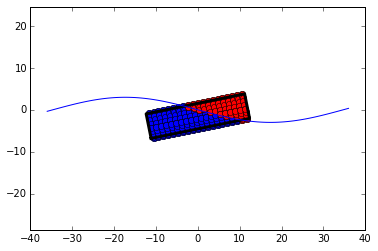

In [23]:
def affichage_P_non_nul(t,angle,z0):
    """reprend les points utilisés pour le calcul de la poussée d'archimède et affiche leur position
    pour vérifier que le test pour le calcul de la pression soit bon"""
    stockX_ok=[]
    stockZ_ok=[]
    stockX_bad=[]
    stockZ_bad=[]
    for i in range(Nl):
        xc=(i+0.5)*L/Nl-L/2
        for j in range(Nth):
            theta=(j+0.5)*2*np.pi/Nth
            
            dF,dM,xx,zz=d_Force_Moment(R,theta,xc,z0,angle,t)
            ## cette condition peut etre modifier pour visualiser différents points:
            ## dF != 0 pour voir si la force de pression est bien calculée que dans l'eau
            ## dF >0 pour voir la bonne répartition de la force de pression
            ## dM >0 pour voir si le couple est dans le bon sens 
            if dF != 0:
                stockX_ok+=[xx]
                stockZ_ok+=[zz]
            else:
                stockX_bad+=[xx]
                stockZ_bad+=[zz]
                
    plt.plot(stockX_ok,stockZ_ok,'bo')                
    plt.plot(stockX_bad,stockZ_bad,'ro')    
    
def photo(t,angle,z0):
    """ montre la position du pelamis à l'instant t et l'état de la mer"""
    affichage_P_non_nul(t,angle,z0)
    coin=np.array([[-L/2,R],[L/2,R],[L/2,-R],[-L/2,-R]])
    rot=np.array([[np.cos(angle),-np.sin(angle)],[np.sin(angle),np.cos(angle)]])
    for i in range(4):
        coin[i]=np.dot(rot,coin[i])
        
    coinX=np.zeros(5)
    coinY=np.zeros(5)
    for i in range(5):
        coinX[i]=coin[i-1,0]
        coinY[i]=coin[i-1,1]+z0
    
    plt.plot(coinX,coinY,'k',linewidth=3)
    
    xm=np.linspace(-3*L/2,3*L/2,100)
    plt.plot(xm,eta(xm,t))
    plt.axis('equal')
    plt.show()
    
    
    
photo(0,0.2,-1.5)
#affichage_P_non_nul(0,0.2,3)

Il reste à résoudre le système d'équation différentielle pour obtenir le mouvement du pélamis.
Dans un premier temps j'utilise une méthode simple d'Euler explicite.
Les équations d'Euler sont:
$$\begin{eqnarray}
v_{z}[i+1]	&=&	v_{z}[i]+\left(\frac{1}{m}\Pi_{a,z}-g\right)dt \\
\dot{\alpha}[i+1]	&=&	\dot{\alpha}[i]-\frac{1}{J}\mathcal{M}\left(\vec{\Pi_{a}}\right)_{y}dt \\
z[i+1]	&=&	Z[i]+v_{z}[i]dt \\
\alpha[i+1]	&=&	\alpha[i]+\dot{\alpha}[i]dt
\end{eqnarray}$$
 

Il faut pour cela fixer des conditions initiales sur le cylindre. On considèrera sa vitesse initiale comme nulle et sa position celle donnée par la statique c'est-à-dire telle que:
$$\vec{\Pi_a}=-m\vec{g}$$. 


In [28]:
def Euler(Tmax,Nt):
    
    #initialisation des vecteurs de stockages
    tt=np.zeros(int(Nt))
    vz=np.zeros(int(Nt))
    dalpha=np.zeros(int(Nt))
    zc0=np.zeros(int(Nt))
    alpha=np.zeros(int(Nt))
    Ftot=np.zeros(int(Nt))
    Mtot=np.zeros(int(Nt))
    zc0[0]= z_statik
    for i in range(0,int(Nt)-1):
        dt=Tmax/Nt
        tt[i+1]=tt[i]+dt
        #print(i, ' -> ',dt,'   ',tt[i],vz[i],dalpha[i],zc0[i],alpha[i])
        Ft,Mt=Force_Moment_total(tt[i],alpha[i],zc0[i])
        Ftot[i]=Ft
        Mtot[i]=-Mt
        #print(J,Mt)
        vz[i+1]=vz[i]+dt*(Ft/m-g)
        dalpha[i+1]=dalpha[i]-Mt/J*dt
        zc0[i+1]=zc0[i]+vz[i]*dt
        alpha[i+1]=alpha[i]+dalpha[i]*dt
        #print('---------------------')
    return tt,vz,dalpha,zc0,alpha,Ftot,Mtot



In [29]:
t_t,t_vz,t_dalpha,t_z0c,t_alpha,t_F,t_M = Euler(5,100)
print(g)

9.81


100000.0
1000.0
9.81


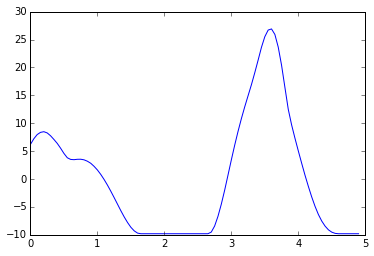

In [30]:
print(m)
print(rho_e)
print(g)
plt.plot(t_t[:-1],t_F[:-1]/m-g)

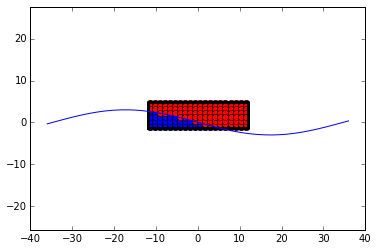

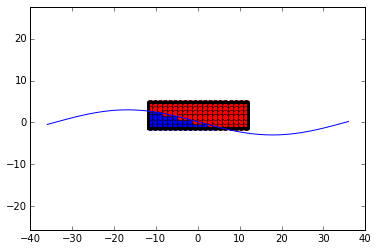

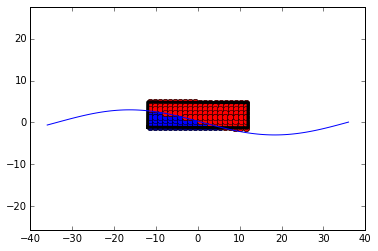

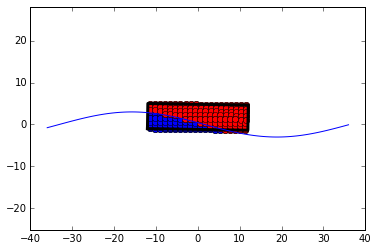

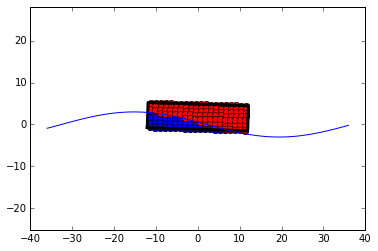

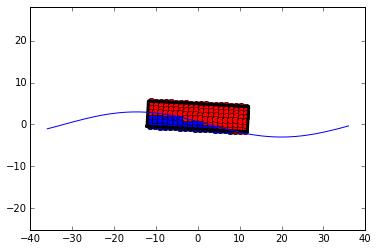

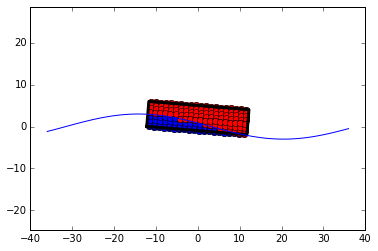

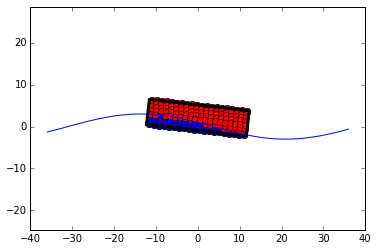

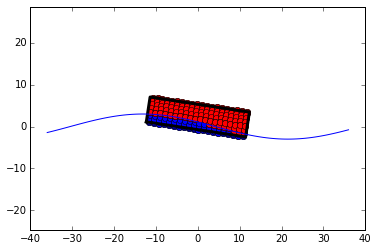

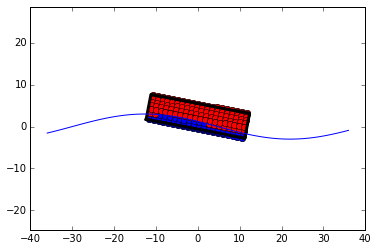

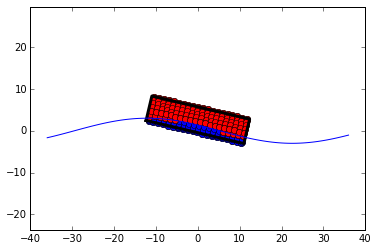

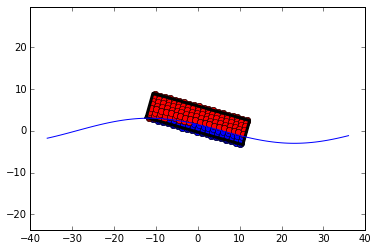

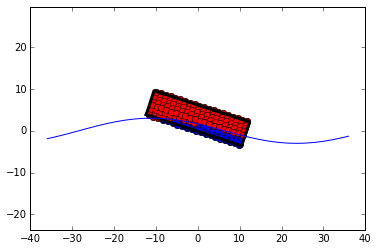

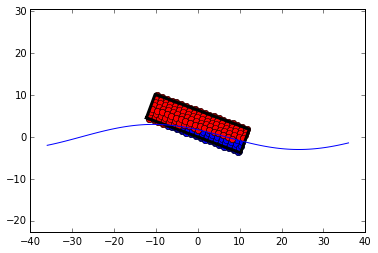

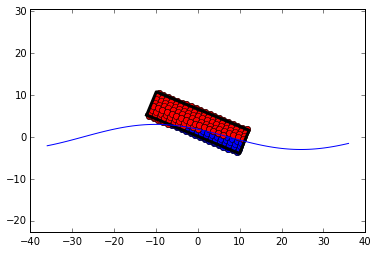

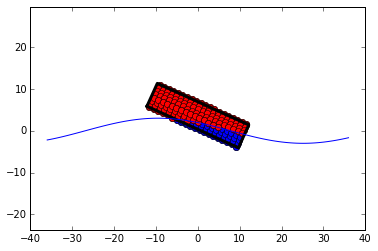

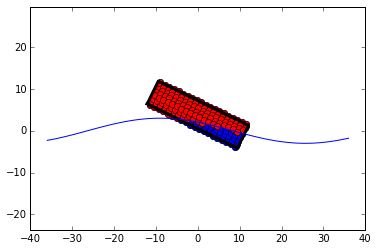

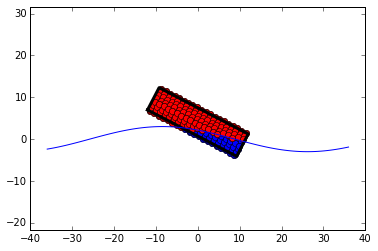

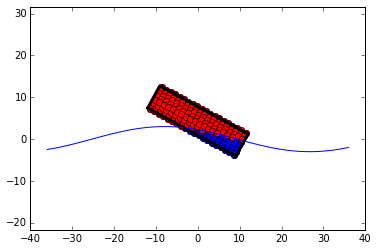

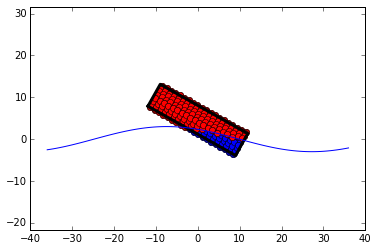

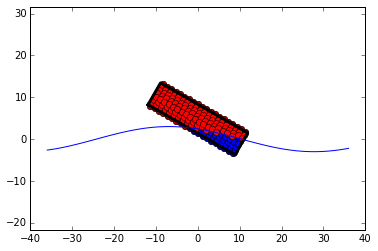

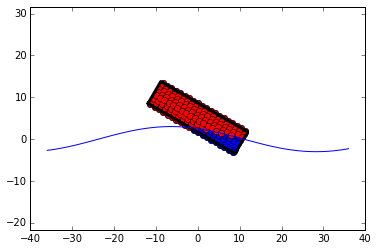

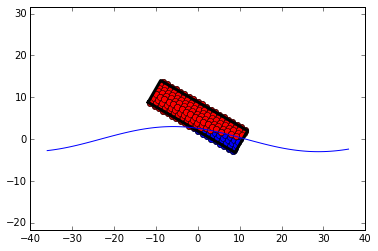

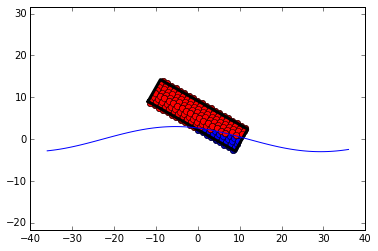

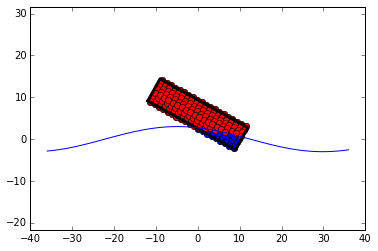

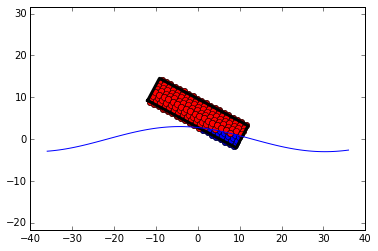

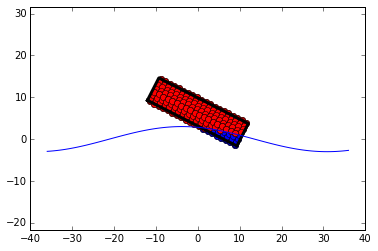

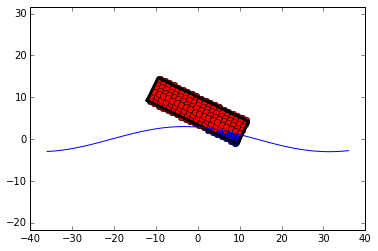

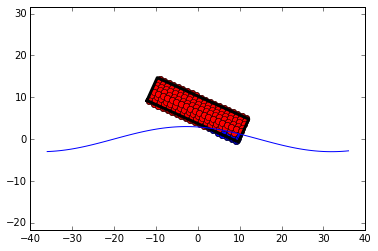

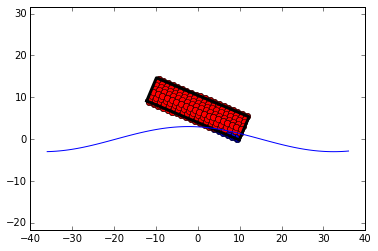

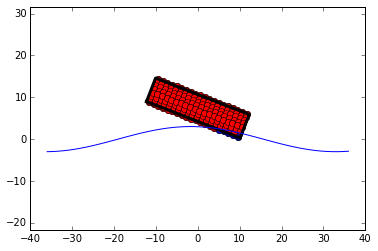

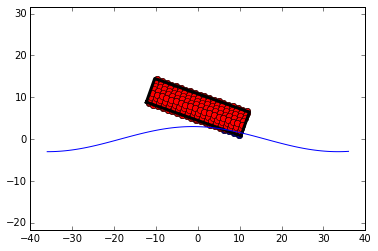

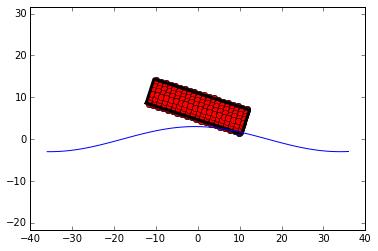

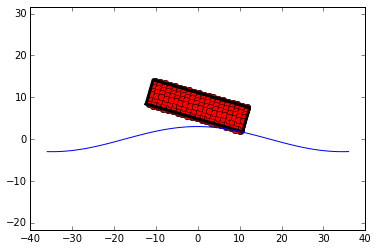

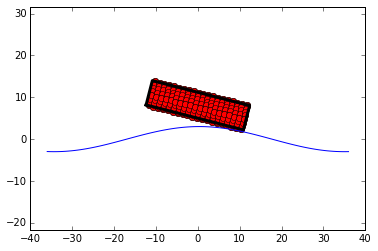

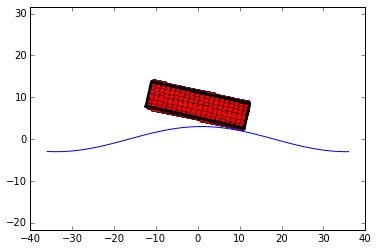

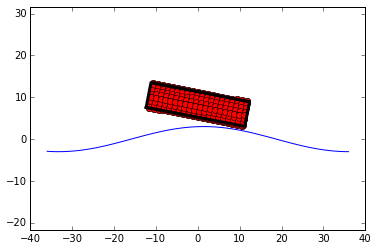

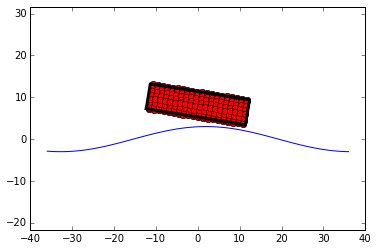

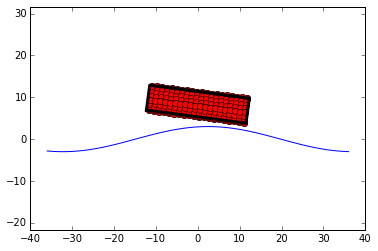

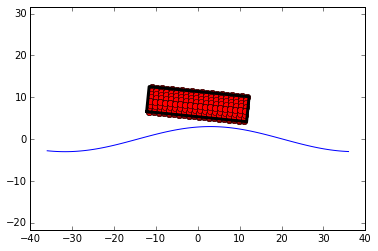

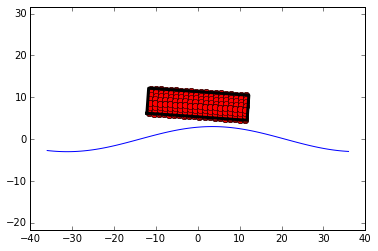

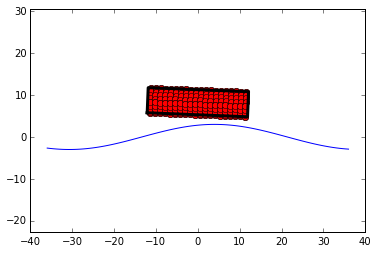

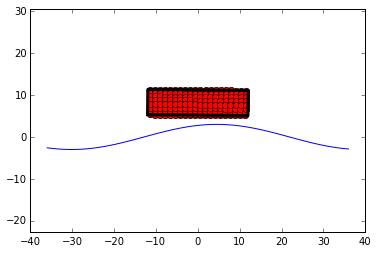

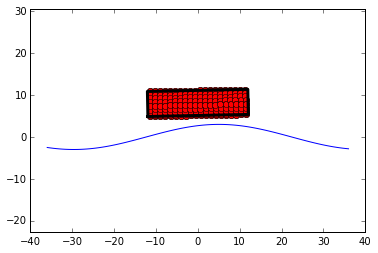

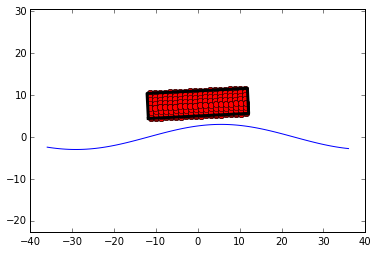

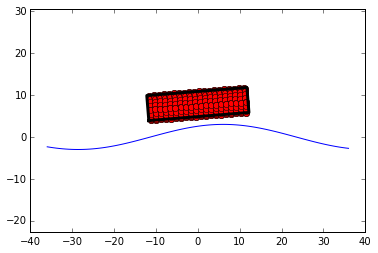

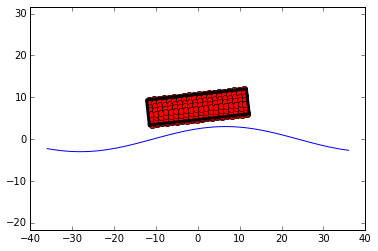

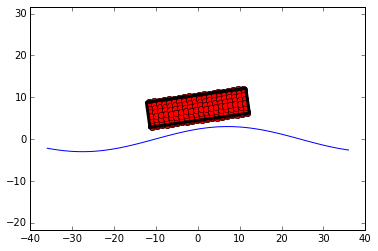

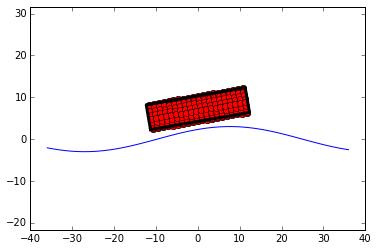

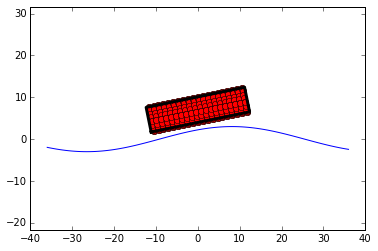

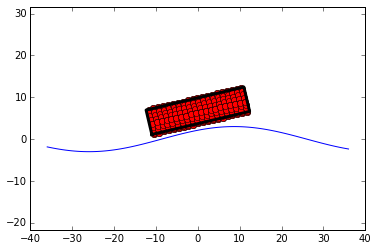

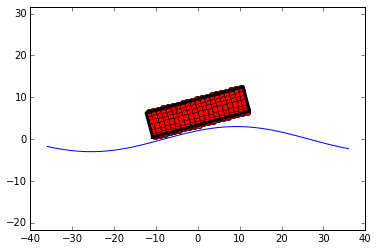

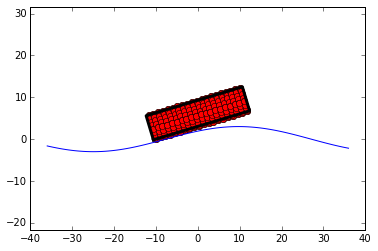

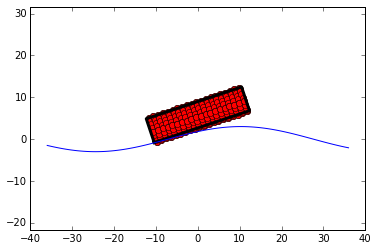

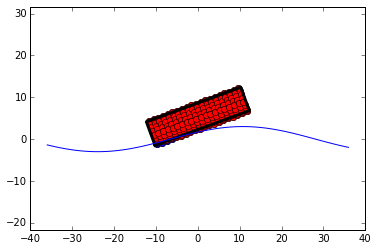

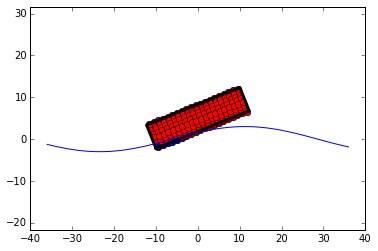

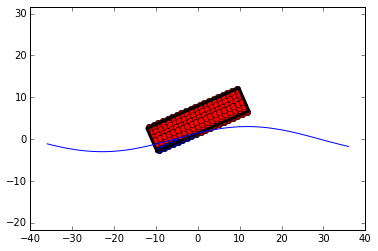

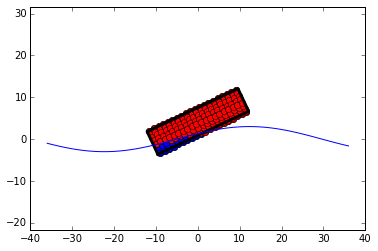

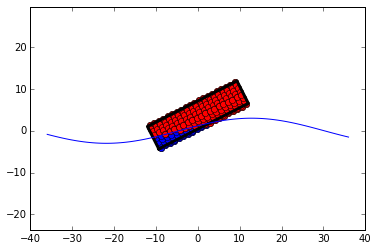

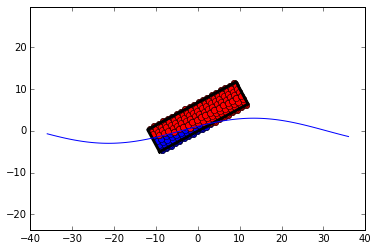

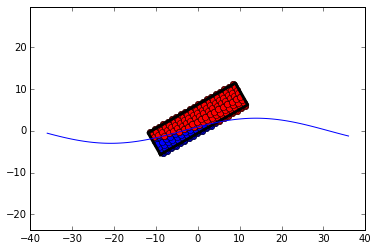

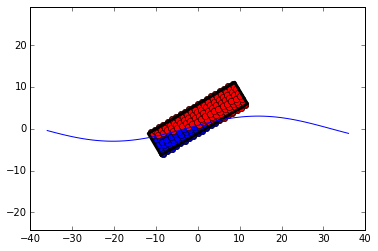

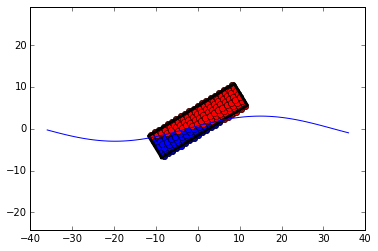

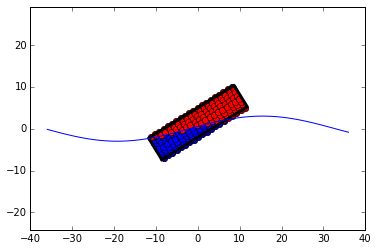

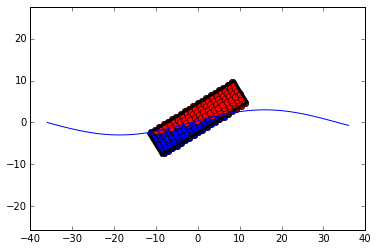

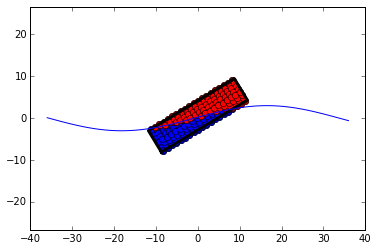

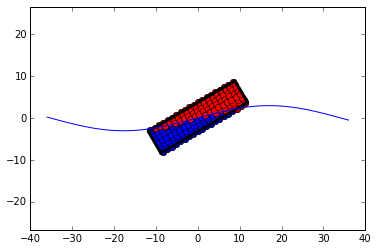

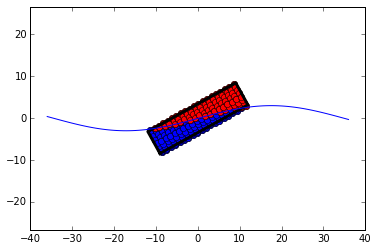

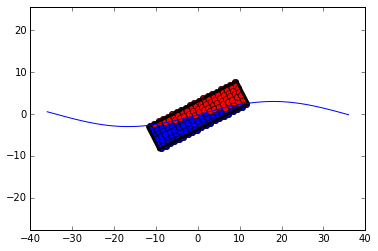

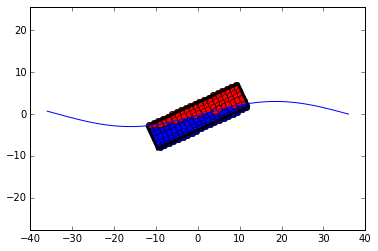

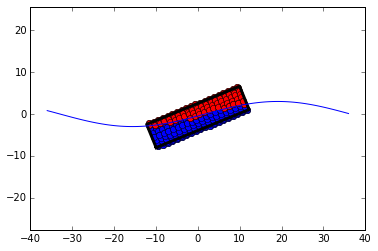

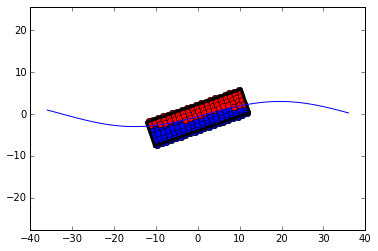

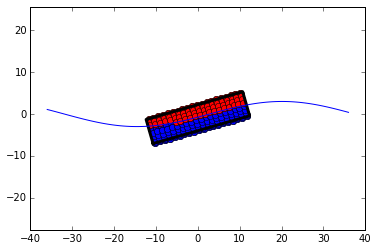

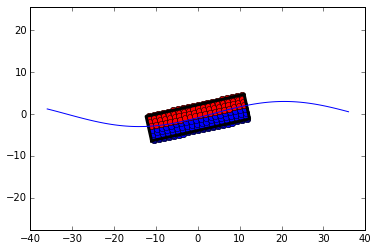

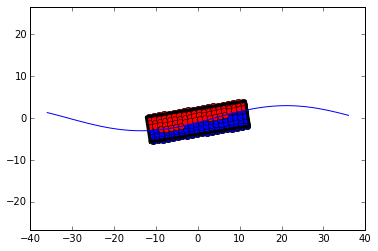

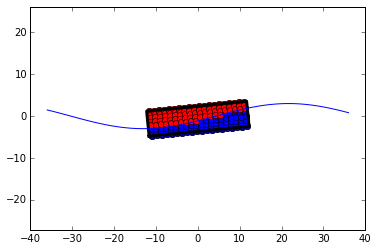

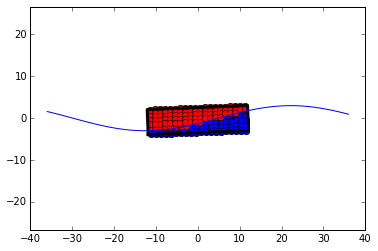

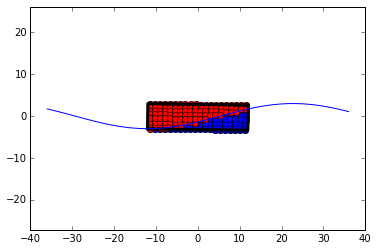

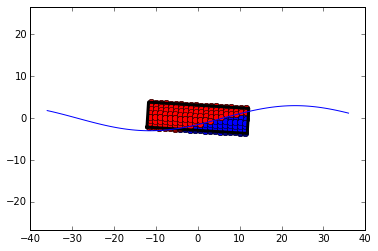

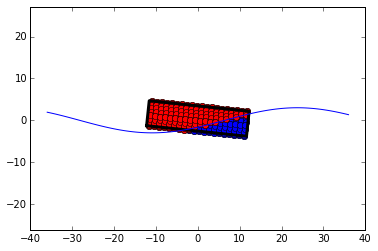

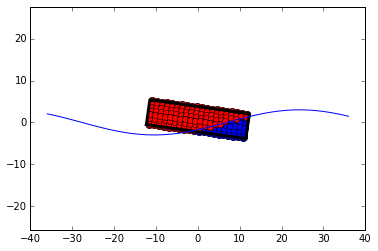

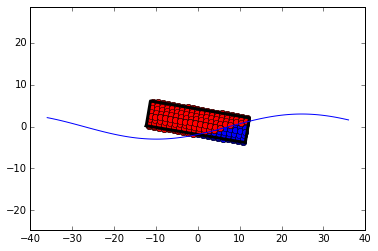

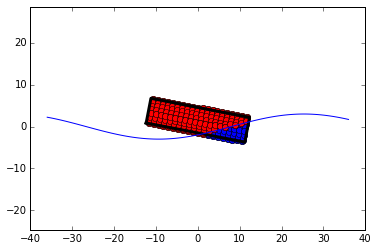

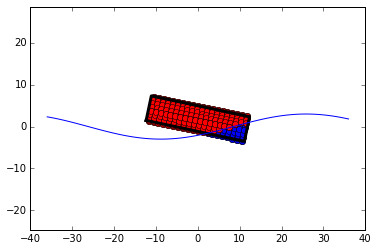

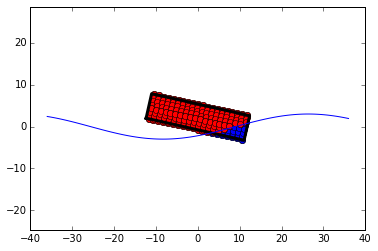

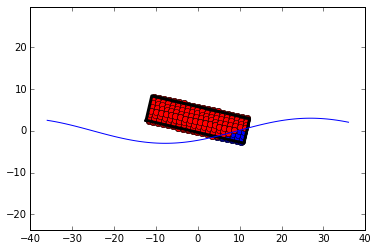

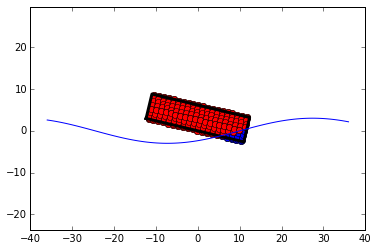

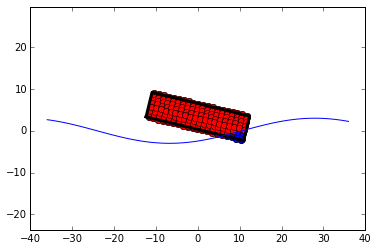

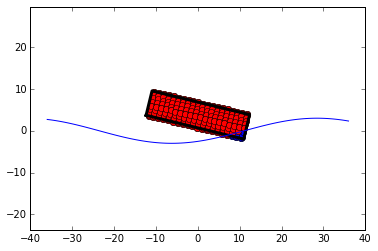

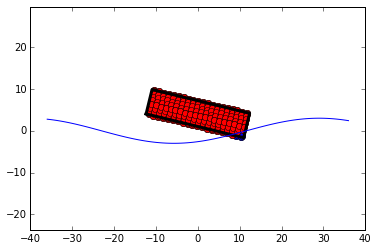

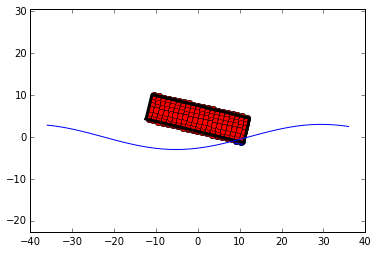

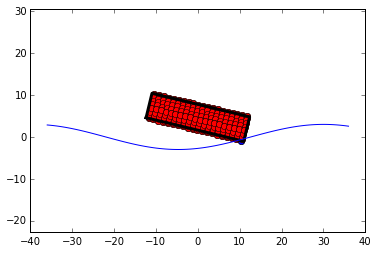

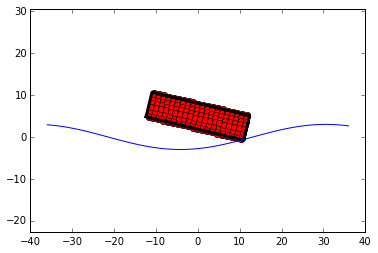

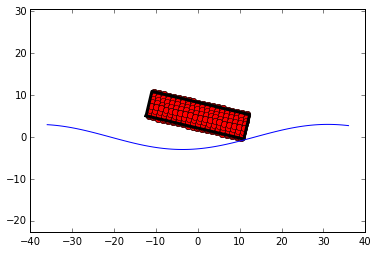

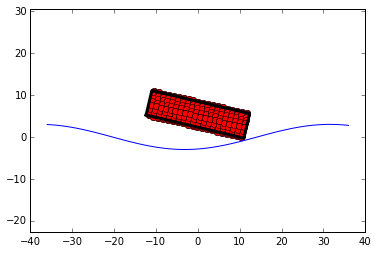

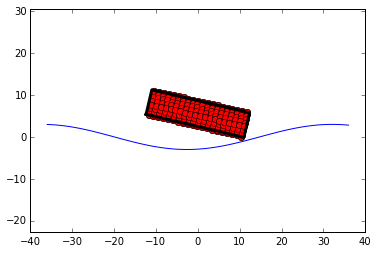

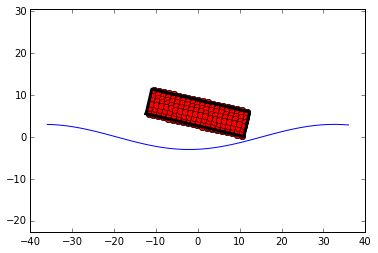

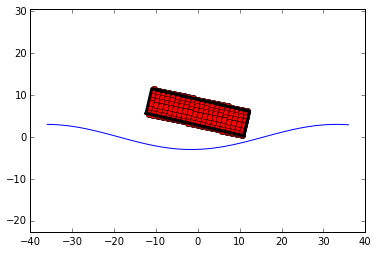

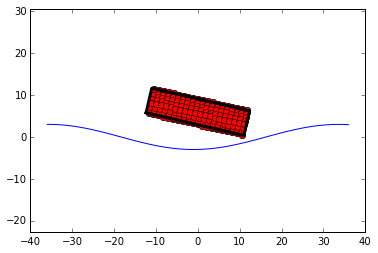

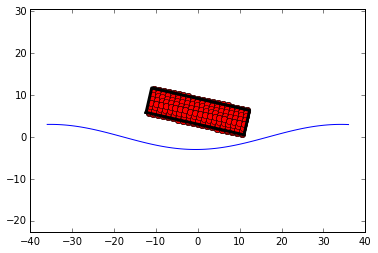

In [31]:
for i in range(100):
    photo(t_t[i],t_alpha[i],t_z0c[i])

## Annexe: Développement pour l'obtention de la matrice de passage
On a trois repère différents. Montrons comment on peut passer de l'un à l'autre:

On a:
$$\begin{eqnarray}
\vec{e_{xc}}	&=&	\cos\alpha\vec{e_{x}}+\sin\alpha\vec{e_{z}} \\
\vec{e_{yc}}	&=&	\vec{e_{y}} \\
\vec{e_{zc}}	&=&	-\sin\alpha\vec{e_{x}}+\cos\alpha\vec{e_{z}} \\
\end{eqnarray} $$
 soit la matrice de passage de $\left(\vec{e_{xc}};\vec{e_{yc}};\vec{e_{zc}}\right)$ à $\left(\vec{e_{x}};\vec{e_{y}};\vec{e_{z}}\right)$:
 $$A_{cyl\rightarrow mer}=\left(\begin{array}{ccc}
\cos\alpha & 0 & -\sin\alpha\\
0 & 1 & 0\\
\sin\alpha & 0 & \cos\alpha
\end{array}\right)$$
 

De même:
$$\begin{eqnarray}
\vec{u_{r}}	&=&	\cos\theta\vec{e_{yc}}+\sin\theta\vec{e_{zc}} \\
\vec{u_{\theta}}	&=&	-\sin\theta\vec{e_{yc}}+\cos\theta\vec{e_{zc}} \\
\vec{u_{z}}	&=&	\vec{e_{xc}} \\
\end{eqnarray} $$
 soit la matrice de passage de $\left(\vec{u_{r}};\vec{u_{\theta}};\vec{u_{z}}\right)$
  à $\left(\vec{e_{xc}};\vec{e_{yc}};\vec{e_{zc}}\right)$:
  $$A_{pol\rightarrow cyl}=\left(\begin{array}{ccc}
0 & 0 & 1\\
\cos\theta & -\sin\theta & 0\\
\sin\theta & \cos\theta & 0
\end{array}\right)$$
 

Matrice de passage de la base polaire liée au cylindre à la base cartésienne de référence (la mer):
$$\left(\begin{array}{ccc}
-\sin\theta\sin\alpha & -\cos\theta\sin\alpha & \cos\alpha\\
\cos\theta & -\sin\theta & 0\\
\sin\theta\cos\alpha & \cos\theta\cos\alpha & \sin\alpha
\end{array}\right)$$
 
Cette matrice s'obtient en faisant: $A_{cyl\rightarrow mer}\times A_{pol\rightarrow cyl}$
 